In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt
from time import time
from random import randint

from keras.datasets import cifar10

from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.layers import Dense, Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.models import Model
from keras.callbacks import TensorBoard

from keras import regularizers
from keras import backend as K

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


Using TensorFlow backend.


In [ ]:
# load data
(Xtrain, ytrain), (Xtest, ytest) = cifar10.load_data()
# one hot encode outputs
ytrain = np_utils.to_categorical(ytrain)
ytest = np_utils.to_categorical(ytest)
numOfclasses = ytest.shape[1]
# perform a transpose reshape from (3,32,32) to (32,32,3)
Xtrain = Xtrain.reshape(50000,3,32,32).transpose(0,2,3,1).astype("uint8")
Xtest = Xtest.reshape(10000,3,32,32).transpose(0,2,3,1).astype("uint8")
# normalize inputs from 0-255 to 0.0-1.0
Xtrain = Xtrain.astype('uint8') / 255.
Xtest = Xtest.astype('uint8') / 255.
# reshape data from (32,32,3) to (,3072)
Xtrain = Xtrain.reshape(-1, 3072)
Xtest = Xtest.reshape(-1, 3072)
print(Xtrain.shape)
print(Xtest.shape)

(50000, 3072)
(10000, 3072)


In [ ]:
scale_train = Xtrain
scale_test = Xtest
# standardscaler = StandardScaler()
pca = PCA()
# fit PCA to dataset
pca.fit(scale_train)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
# generate transformed dataset
Xtrain_pca = pca.transform(scale_train)
Xtest_pca = pca.transform(scale_test)
# reshape data from (,3072) to (32,32,3)
Xtrain_pca = Xtrain_pca.reshape(-1, 32,32,3)
Xtest_pca = Xtest_pca.reshape(-1, 32,32,3)
print(Xtrain_pca.shape)
print(Xtest_pca.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32,32,3), kernel_constraint=maxnorm(3)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(numOfclasses, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [ ]:
# Compile model
epochs = 50
lrate = 0.01
decay = lrate/epochs
sgd = keras.optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
history = model.fit(Xtrain_pca, ytrain, validation_data=(Xtest_pca, ytest), epochs=epochs, batch_size=32)

Epoch 1/50
1563/1563 [==============================] - 9s 5ms/step - loss: 1.8114 - accuracy: 0.3428 - val_loss: 1.5988 - val_accuracy: 0.4174
Epoch 2/50
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6069 - accuracy: 0.4207 - val_loss: 1.4894 - val_accuracy: 0.4596
Epoch 3/50
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5261 - accuracy: 0.4513 - val_loss: 1.4275 - val_accuracy: 0.4847
Epoch 4/50
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4639 - accuracy: 0.4753 - val_loss: 1.4055 - val_accuracy: 0.4882
Epoch 5/50
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4168 - accuracy: 0.4937 - val_loss: 1.3672 - val_accuracy: 0.5077
Epoch 6/50
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3756 - accuracy: 0.5069 - val_loss: 1.3979 - val_accuracy: 0.4953
Epoch 7/50
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3394 - accuracy: 0.5193 - val_loss: 1.3277 - val_accuracy:

In [ ]:
# Final evaluation of the model
Accuracy = model.evaluate(Xtest_pca, ytest)
print("Accuracy: %.2f%%" % (Accuracy[1]*100))

313/313 [==============================] - 1s 2ms/step - loss: 1.4444 - accuracy: 0.5641
Accuracy: 56.41%


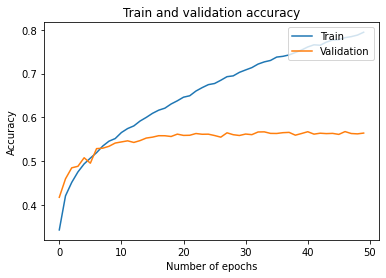

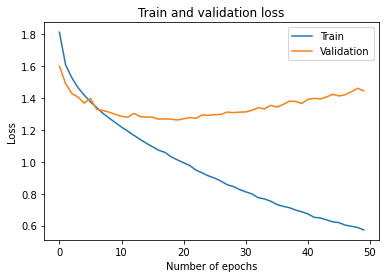

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train and validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
model.save('./savedModel' + '.h5')
model2 = tf.keras.models.load_model('savedModel.h5')
class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
imgarc = [None] * 10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


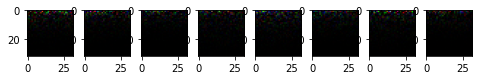

In [ ]:
# plotting 8 reconstructed images that will be predicted
fig = plt.figure(figsize=(8,8))

for i in range(8):
  ax = fig.add_subplot(8, 8, i+1)
  ax.imshow(Xtest_pca[i], cmap = plt.cm.bone)

plt.show()

In [ ]:
# predicted labels from CNN for images above
for img in range(0,8):
  predict = model2.predict_classes(Xtest_pca[[img],:])
  print("predicted for image[" + str(img+1) +"]: " + str(predict[0]) + ' ' + str(class_name[predict[0]]))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
predicted for image[1]: 3 cat
predicted for image[2]: 9 truck
predicted for image[3]: 8 ship
predicted for image[4]: 0 airplane
predicted for image[5]: 6 frog
predicted for image[6]: 6 frog
predicted for image[7]: 1 automobile
predicted for image[8]: 6 frog


cat
ship
ship
airplane
frog
frog
automobile
frog


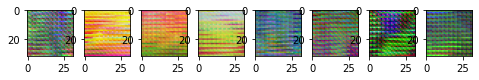

In [ ]:
# plotting original images from above
fig = plt.figure(figsize=(8,8))

for i in range(8):
  ax = fig.add_subplot(8, 8, i+1)
  ax.imshow(Xtest[i].reshape(32,32,3), cmap = plt.cm.bone)

  imgarc = ytest[i]
  for j in range(0,len(imgarc)):
    if imgarc[j]== 1:
      print(class_name[j])
      break

plt.show()
